In [1]:
from google.colab import drive
drive.mount('/content/drive')

directory_path = '/content/drive/My Drive/lab/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Auther: Seongwoo Kim
#한 이미지 내의 연속된 숫자를 세는 프로그램

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.utils.model_zoo as model_zoo
from PIL import Image


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features #convolution
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )#FC layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) #Convolution 
        x = self.avgpool(x) # avgpool
        x = x.view(x.size(0), -1) #
        x = self.classifier(x) #FC layer
        return F.log_softmax(x, dim=1)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'] # 16 +3 =vgg 19
}

In [3]:
count_model = VGG(make_layers(cfg['A']), num_classes=4, init_weights=True).to(DEVICE)
count_model.load_state_dict(torch.load(directory_path + 'VGG_count_model.pt'))
center_model = VGG(make_layers(cfg['B']), num_classes=20, init_weights=True).to(DEVICE)
center_model.load_state_dict(torch.load(directory_path + 'VGG_center_model.pt'))
rec_model = VGG(make_layers(cfg['A']), num_classes=10, init_weights=True).to(DEVICE)
rec_model.load_state_dict(torch.load(directory_path + 'VGG_ver2_model.pt'))

<All keys matched successfully>

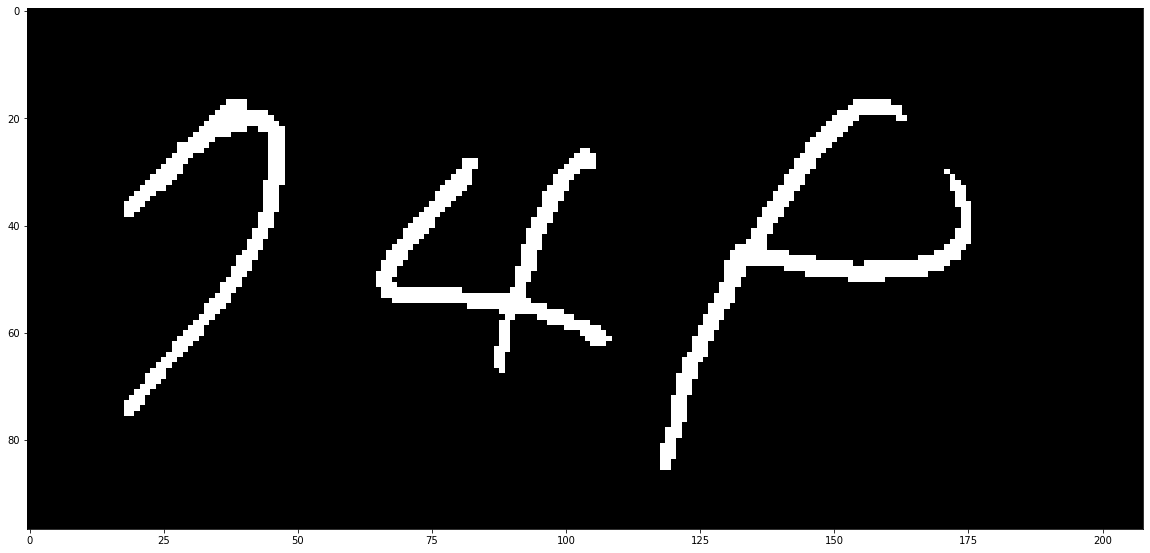

[[0, 1, 2]]


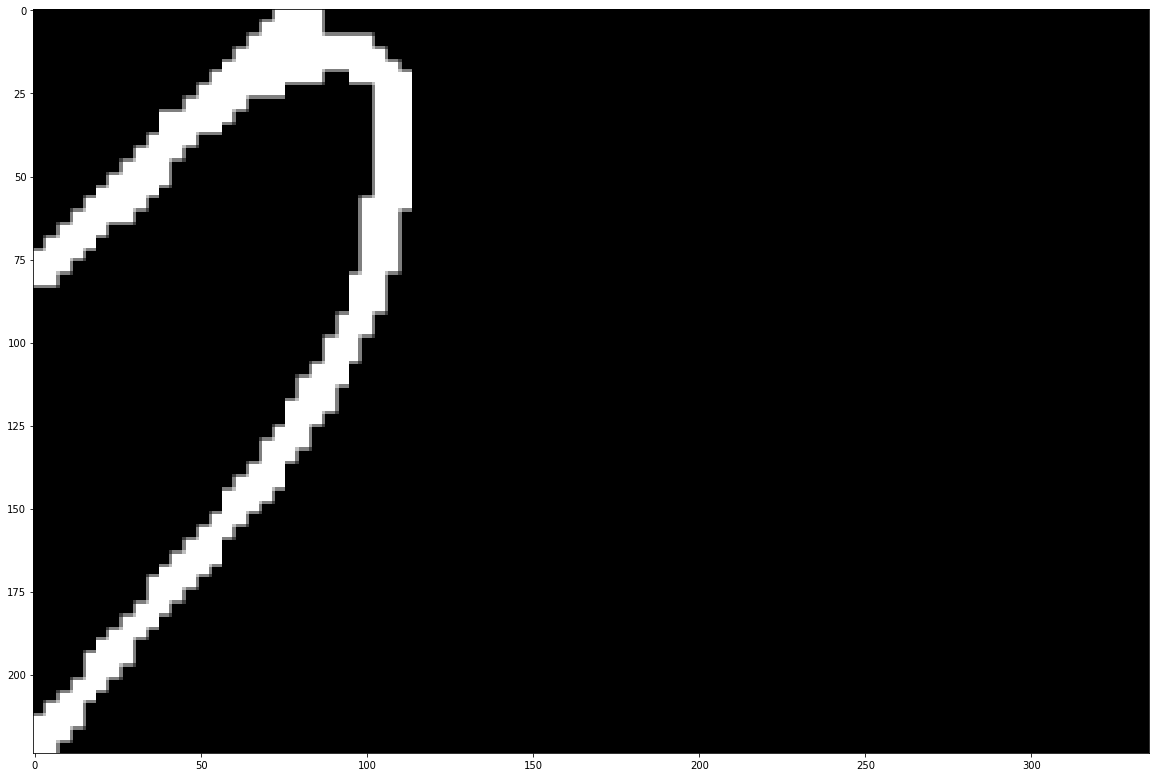

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


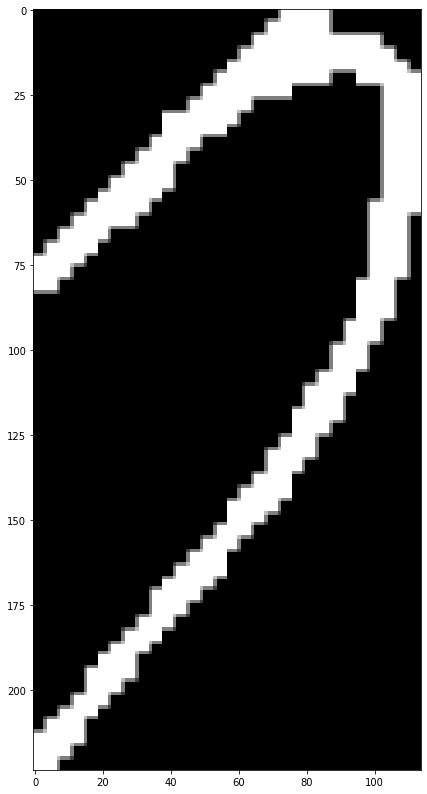

60


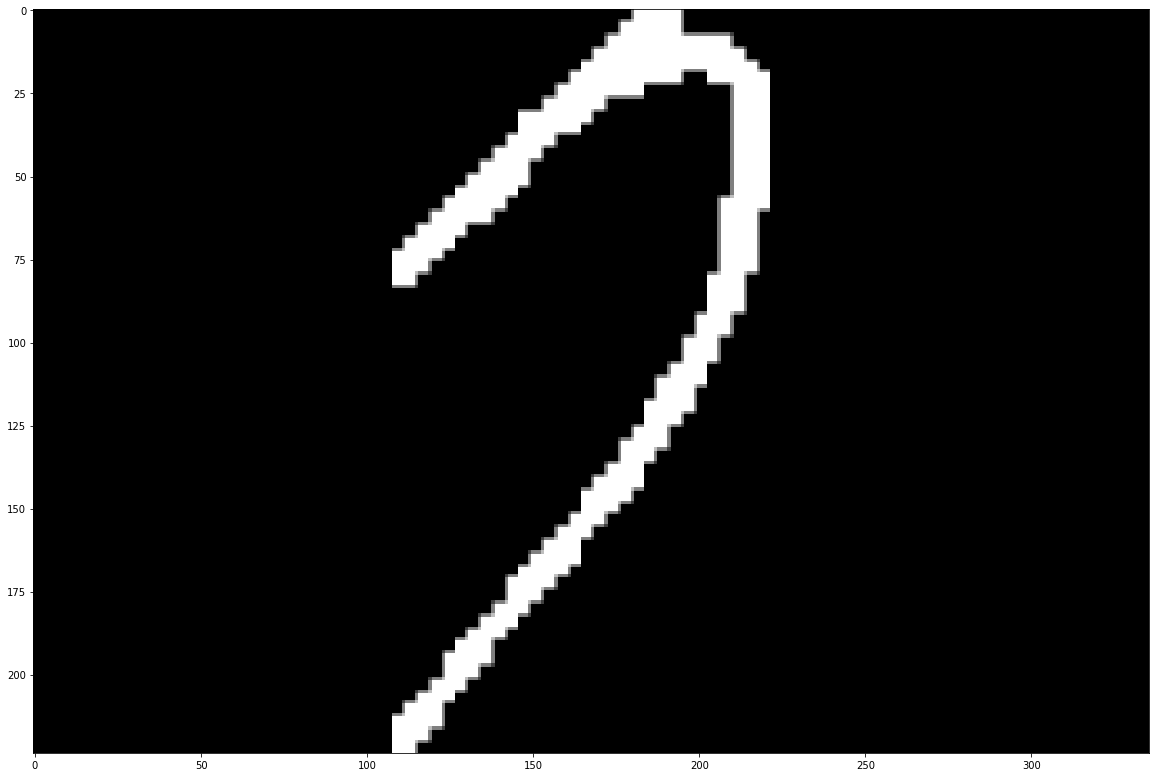

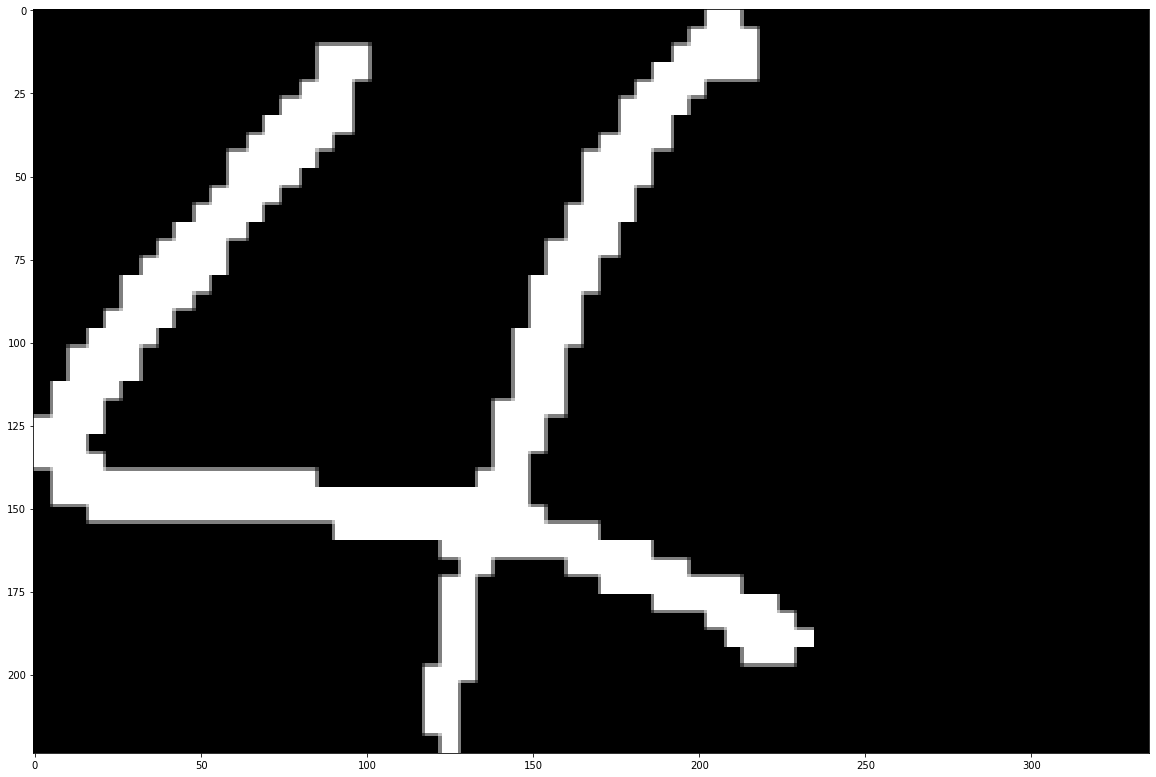

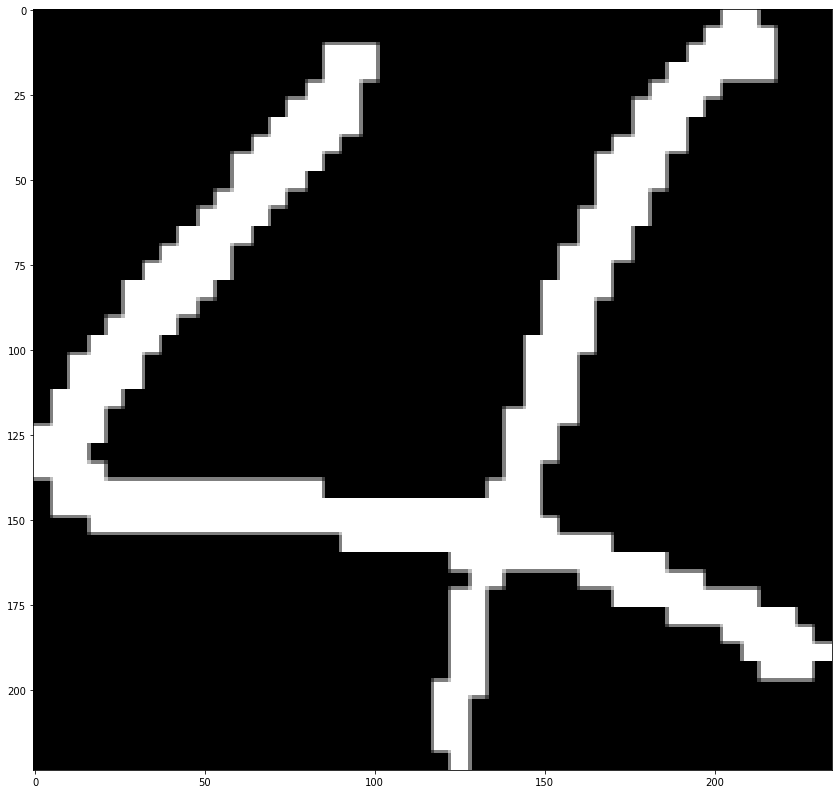

124


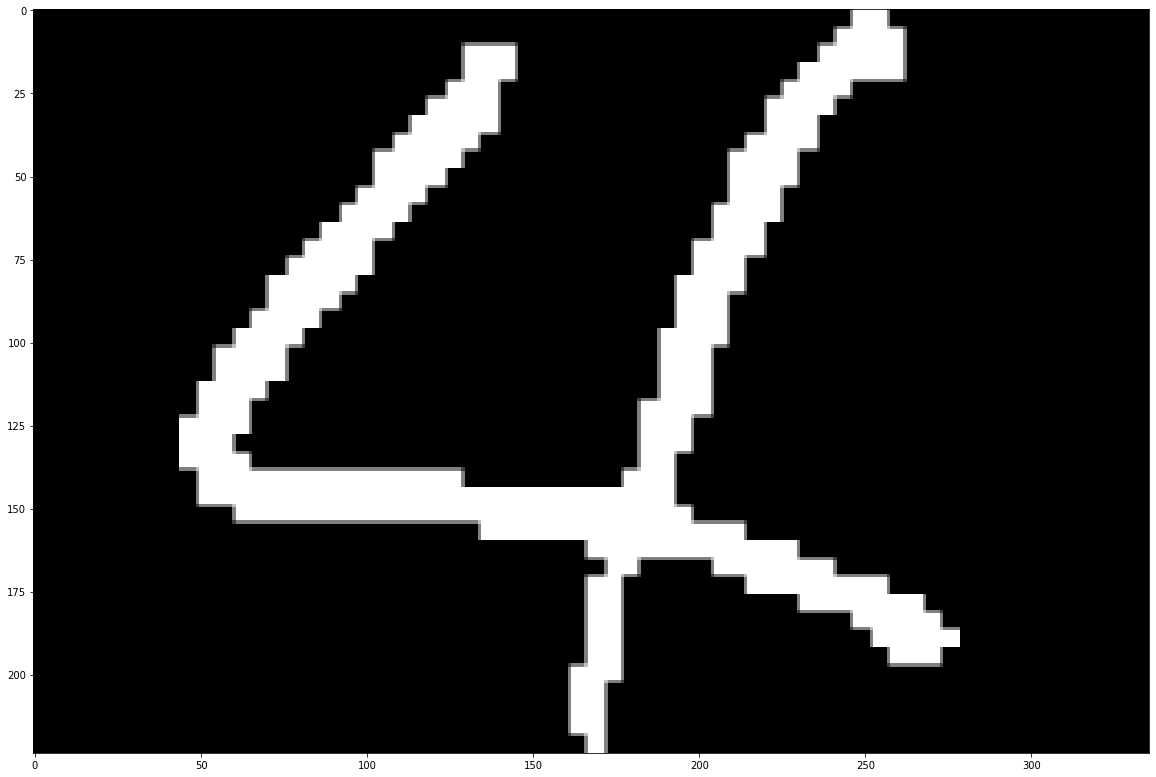

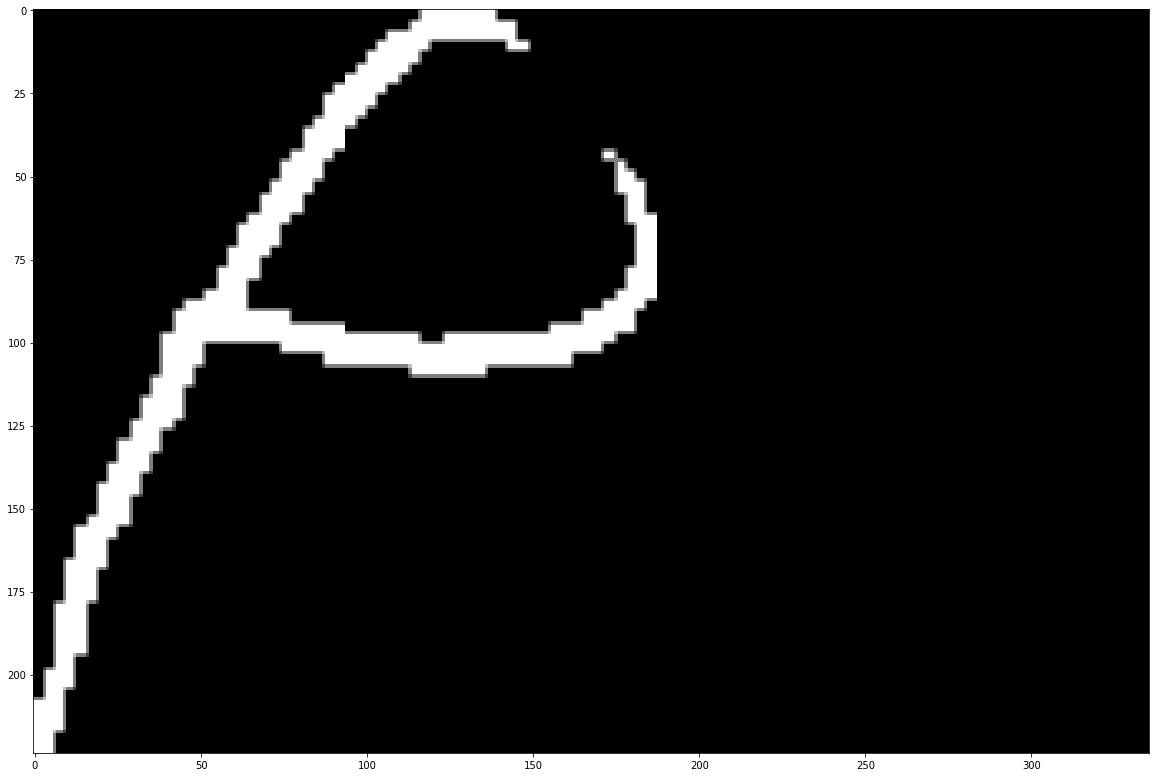

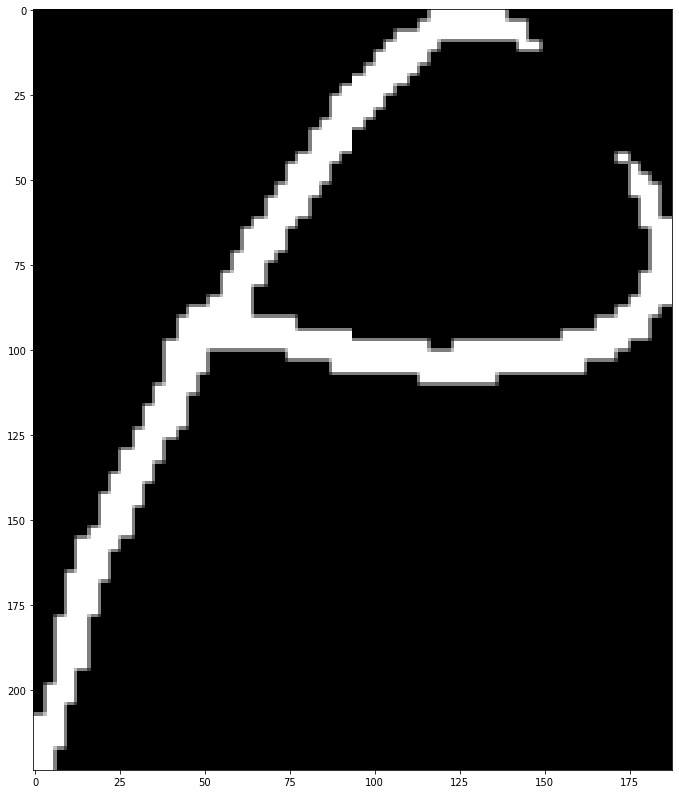

99


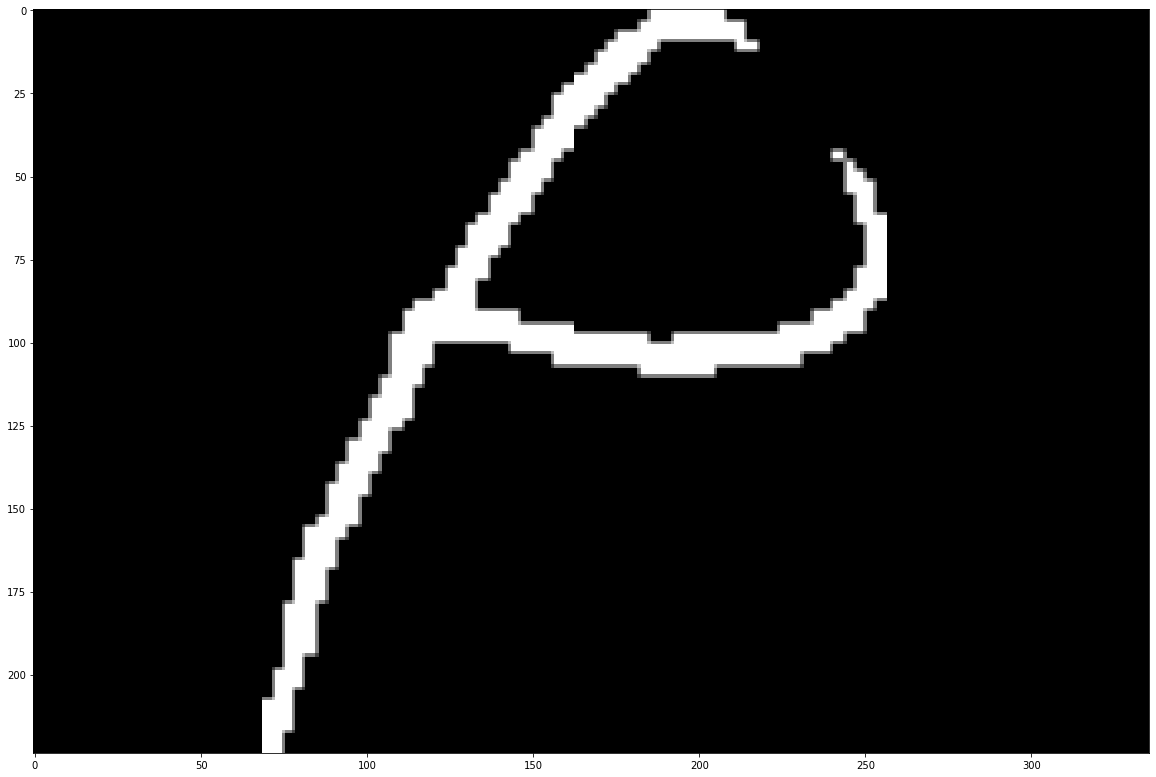

744


In [7]:
def process(pred, num):
  _, length = pred.shape
  peak_list = list()
  for n in range(num):
    targetidx = pred.max(dim=1)[1].item()
    peak_list.append(targetidx)
    for j in range(-1, 2):
      if(0 <= targetidx+j  and targetidx+j < length):
        pred[0,targetidx+j].sub_(2)
  peak_list.sort()
  return peak_list

def showimg(tensor):
  npimg   = utils.make_grid(tensor, padding=0)
  npimg = npimg.numpy()
  plt.figure(figsize=(20, 14))
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()
  
def find_contour(img):
  Img = (img * 255).type(dtype=torch.uint8)
  Img = Img.cpu().numpy().transpose(1, 2, 0)
  _,W, H = img.shape
  Img_size = W * H
  contours, hierachy = cv2.findContours(Img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  group = list()
  for n in range(len(contours)):
      area = cv2.contourArea(contours[n])
      if(area > Img_size * 0.0008  and hierachy[0,n,3] == -1):
          group.append((area, n))
  group.sort()
  if(len(group)== 0):
    print('error')
    return torch.zeros(1,28,28)
  
  for n in range(len(group)):
    x, y, w, h = cv2.boundingRect(contours[group[n][1]])
    if(n < len(group) - 1):
      img[:,y:y+h,x:x+w] = 0
  return img[:,y:y+h,x:x+w]

def resizing(t, y, x):
  _,_,height,width = t.shape
  res = torch.zeros(1,1,y,x).to(DEVICE)
  if(height/width > y/x):
    t = F.interpolate(t, size=(y, round(width * y / height)), mode='area')
    _,_,height,width = t.shape
    res[:,:,:,0:width].add_(t)
  else:
    res = F.interpolate(t, size=(y, x), mode='area').to(DEVICE)
  return res

def tocenter(t,x, x_rad):
  _,height,width = t.shape
  if(x + x_rad < width):
    t = t[:,:,:x + x_rad]
  else:
    t = torch.cat((t,torch.zeros(1,height,x + x_rad - width).to(DEVICE)), dim=2)
  if(x > x_rad):
    t = t[:,:,x - x_rad:]
  else:
    t = torch.cat((torch.zeros(1,height,x_rad - x).to(DEVICE),t), dim=2)
  return t

img_path=directory_path + "seq_image/seq749.jpg"         #이미지 파일 주소 할당
Img = cv2.imread(img_path)                      #이미지 객체 할당
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)     #컬러 이미지를 흑백으로 변환
Img = cv2.GaussianBlur(Img,(3,3),0)
#가우시안 블러를 통해 이미지를 부드럽게 만듦 + 숫자가 굵어지는 효과
ret,Img = cv2.threshold(Img,0,255,cv2.THRESH_OTSU) #OTSU를 통해 노이즈 제거
if(Img.mean() > 127):
    ret,Img = cv2.threshold(Img,0,255,cv2.THRESH_BINARY_INV)
    #Binary thresholding 이후 색상값 반전
W, H = Img.shape
Img_size = W * H

contours, hierachy = cv2.findContours(Img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                  #윤곽 정보 객체 생성
Img = ToTensor()(Img)

di = dict()       #key: 특정 크기 이상의 컨투어의 인덱스 value: 탐색이 진행되었는지
for n in range(len(contours)):
    area = cv2.contourArea(contours[n])
    if(area > Img_size * 0.001 and area < Img_size * 0.8):
                  #윤곽의 넓이가 너무 작거나 크면 제외
        if(hierachy[0,n,3] == -1):
          di[n] = False
group = list()
#같은 계층의 윤곽을 재귀적으로 찾는 함수
def findpeer(ele, L, D):
    if(ele not in D or D[ele] == True):
      return
    D[ele] = True
    L.append(ele)
    front = hierachy[0, ele, 0].item()
    back = hierachy[0, ele, 1].item()
    if(front != -1): findpeer(front, L, D)
    if(back != -1): findpeer(back, L, D)
    
for key in di:
    if(di[key] == True): #이미 group에 추가된 윤곽일 경우 넘어감
        continue
    L = list()
    group.append(L)
    findpeer(key, L, di) #이웃한 hierachy는 같은 리스트에 넣어줌

group.sort(key=len) #서브리스트의 길이로 sorting
Imgs = list()       #숫자들을 자른 이미지를 담을 리스트

if(len(group)== 0):
  raise Exception('글자를 인식하지 못했습니다')

for idx in group[len(group)-1]:                  #가장 비슷한 hierachy가 많은 윤곽 그룹을 선택
  x, y, w, h = cv2.boundingRect(contours[idx])
  empty_image = torch.zeros(1,h,w)
  empty_image.add_(Img[:, y:y+h, x:x+w])
  Imgs.append((x,empty_image,w/h))
Imgs.sort()


#이미지 그림으로 보여주는 부분
showimg(Img[0,:,:])
print(group)



res = ''
for n in range(len(Imgs)):          #각 숫자의 이미지를 담은 리스트에서 이미지 추출
    Img = Imgs[n][1]
    Img = find_contour(Img).unsqueeze(0)
    rImg = resizing(Img.to(DEVICE), 224,336) #224 x 224 크기로 이미지 사이즈 조절
    showimg(rImg[0].cpu())
    digit_count = count_model(rImg).max(1, keepdim=True)[1].item() + 1   #이미지 내의 숫자가 몇자리숫자인지 반환
    center_point = F.softmax(center_model(F.interpolate(Img.to(DEVICE), size=(224,336), mode='area')))                             #slice모델에서 결과 받은 결과를 softmax
    peak_list = process(center_point, digit_count)                         #3자리 숫자일 경우 3개의 peak를 골라줌
    if(digit_count == 1): peak_list = [10]
    sliced_img = list()                                                 #자른 이미지가 들어갈 리스트
    Img = F.interpolate(Img, size=(224,round(224*Imgs[n][2])), mode='area').to(DEVICE)
    showimg(Img[0].cpu())
    for ele in peak_list:
        centre = round(ele * 224*Imgs[n][2] / 19)
        print(centre)
        sliced_img.append(tocenter(Img.squeeze(0),centre,168).unsqueeze(0))           #peaklist를 토대로 연속된 숫자 자름
    for ele in sliced_img:                                              
        showimg(ele[0].cpu())
        img_transform = transforms.Compose([
                       transforms.Normalize((0.1307,),(0.3881,))
                       #MNIST 데이터셋의 평균과 표준편차                
        ])
        Img = img_transform(ele.squeeze(0)).unsqueeze(0).to(DEVICE)
        rec_model.eval()
        output = rec_model(Img)
    #CNN모델에서 숫자를 인식한 뒤 softmax된 output 받음
        pred = output.max(1, keepdim=True)[1].item()
    #가장 확률이 높은 인덱스를 예측값으로 받음
        res += str(pred)
print(res)